# Find STAC Imagery to use using Pystac-client

We will be using the SAT-Client library to search for a library
https://github.com/sat-utils/sat-search

We can install it using: `pip install pystac-client`

We will be accessing the Sentinel-2 L2A datasets. We can read the documentation on this particular data set here: https://roda.sentinel-hub.com/sentinel-s2-l2a/readme.html

## Requirements

- Python version
- Stac version
- OS

## Docker Container


**Objectives**

-  learn how to use Stac Search to search for and download imagery


Set-up: 


1. Ensure your configuration options include `AWS_NO__SIGN_REQUEST = YES`

 https://gdal.org/user/virtual_file_systems.html

 https://github.com/cogeotiff/rio-tiler/issues/19

 https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

 https://github.com/sentinel-hub/custom-scripts

If the same URL is to be used over and over, define an environment variable to be used :
`os.environ['STAC_API_URL']=https://earth-search.aws.element84.com/v0`

In [1]:
import os
# Set environment
os.environ['AWS_NO_SIGN_REQUEST']='YES'

First we need to use the `Client` function from pystac_client. Client takes two arguments `self` and `url`. We can pass in a url that we know and assign it to `url`. The other option is to set an environment variable with the url we want to access by default and Client will automatically know to use the environment variable. 

Below we are using the `inspect` library to view the arguments Client accepts. You can usually also find this information in documentation for a specific package.

In [2]:
# Import 
from pystac_client import Client
#import the inspect library
import inspect

#Inspect the Client function's arguments 
inspect.getfullargspec(Client).args


['self',
 'id',
 'description',
 'title',
 'stac_extensions',
 'extra_fields',
 'href',
 'catalog_type']

Here we can see the `Client` function references `self`,
 'id',
 'description',
 'title',
 'stac_extensions',
 'extra_fields',
 'href',
 'catalog_type'

We are going to use the url: `'https://earth-search.aws.element84.com/v0` which contains Sentinel data. There are a lot of ways to structure your query for the search. Below are a few different options for searching.  You can search for imagery that is within a specific bounding box, between dates, specific cloud coverage and many other attributes.

These fields include:

**bbox**: bounding box of the form [minlon, minlat, maxlon, maxlat]

**intersects**: A GeoJSON geometry

**time:** A single date-time, a period string, or a range (seperated by /)

**sort:** A dictionary of fields to sort along with ascending/descending

**query**: Dictionary of properties to query on, supports eq, lt, gt, lte, gte




To use the Python library, first a `Client` instance is created for a specific STAC API (use the root URL).
A **Catalog** is the starting point for navigating a STAC. You can think of a catalog as a directory structure. The top level directory is the catalog, that contains other directories and files. For STAC, these other directories can be other catalogs (so a catalog within a catalog) or items. 



In [3]:
from pystac_client import Client
#catalog or api?
catalog = Client.open("https://earth-search.aws.element84.com/v0")


In [4]:
child_links = catalog.get_links('child')
print(child_links)
len(child_links)

[<Link rel=child target=https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a>, <Link rel=child target=https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l1c>, <Link rel=child target=https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs>, <Link rel=child target=https://earth-search.aws.element84.com/v0/collections/landsat-8-l1-c1>]


4

This Catalog contains STAC Collections. Here we list the collection IDs and titles that are available:

In [26]:
collections = catalog.get_children()
for collection in collections:
    print(f"{collection.id} - {collection.title}")

sentinel-s2-l2a - Sentinel 2 L2A
sentinel-s2-l1c - Sentinel 2 L1C
sentinel-s2-l2a-cogs - Sentinel 2 L2A COGs
landsat-8-l1-c1 - Landsat-8 L1 Collection-1


To get a single catalog link :

In [5]:
first_child_link = catalog.get_single_link('child')
first_child_link

<Link rel=child target=https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a>

To search a specific catalog for our study area, defined by a bbox - we can return how many items are found that match our search

In [6]:
mysearch = catalog.search(collections=['sentinel-s2-l2a-cogs'], bbox=[-72.5,40.5,-72,41], max_items=10)
print(f"{mysearch.matched()} items found")

2254 items found


Warning : This method for searching is implemented if the API conforms to the STAC API - Item SEARCH spec and contains a link with a "rel" type of "search" in its root catalog.
If the API does not meet either of these criteria, this method will raise a `NotImplementedError`.

In [7]:
for item in mysearch.get_items():
    print(item.id)



S2A_19TBE_20210919_0_L2A
S2A_18TYK_20210919_0_L2A
S2A_18TYL_20210919_0_L2A
S2A_19TBF_20210919_0_L2A
S2A_18TYK_20210916_0_L2A
S2A_19TBE_20210916_0_L2A
S2A_18TYL_20210916_0_L2A
S2A_19TBF_20210916_0_L2A
S2B_18TYK_20210914_0_L2A
S2B_19TBE_20210914_0_L2A


To get all of the Items from a search as a single pystac item collection use the `get_all_items` function.
You can save the results of your search as a json file for reproducibility.

In [8]:
items = mysearch.get_all_items()
items.save('items.json')

In [84]:
col = mysearch.get_item_collections()
col.

TypeError: 'generator' object is not callable

We can also check out the id of the item and the date time for a particular item. Here we are using `items` to store the results from our search as a **list**.

In [79]:
items = list(mysearch.get_items())
for item in items:
    print(f"{item.id}: {item.datetime}")

S2B_18TYK_20210921_0_L2A: 2021-09-21 15:41:56+00:00
S2B_19TBE_20210921_0_L2A: 2021-09-21 15:41:56+00:00
S2B_18TYL_20210921_0_L2A: 2021-09-21 15:41:45+00:00
S2B_19TBF_20210921_0_L2A: 2021-09-21 15:41:44+00:00
S2A_19TBE_20210919_0_L2A: 2021-09-19 15:52:00+00:00
S2A_18TYK_20210919_0_L2A: 2021-09-19 15:52:00+00:00
S2A_18TYL_20210919_0_L2A: 2021-09-19 15:51:46+00:00
S2A_19TBF_20210919_0_L2A: 2021-09-19 15:51:46+00:00
S2A_18TYK_20210916_0_L2A: 2021-09-16 15:42:01+00:00
S2A_19TBE_20210916_0_L2A: 2021-09-16 15:42:00+00:00


We can use the eo property of our items to list the cloud cover for our study area.

In [46]:
for item in items:
    print(f"{item.id}: {item.properties['eo:cloud_cover']}")

S2A_19TBE_20210919_0_L2A: 8.39
S2A_18TYK_20210919_0_L2A: 9.81
S2A_18TYL_20210919_0_L2A: 0
S2A_19TBF_20210919_0_L2A: 0
S2A_18TYK_20210916_0_L2A: 99.8
S2A_19TBE_20210916_0_L2A: 99.7
S2A_18TYL_20210916_0_L2A: 96.81
S2A_19TBF_20210916_0_L2A: 96.51
S2B_18TYK_20210914_0_L2A: 44.54
S2B_19TBE_20210914_0_L2A: 41.71


We’ll grab an item with low cloudiness:

In [44]:
selected_item = sorted(items, key=lambda item: item.properties["eo:cloud_cover"])[0]



<Item id=S2A_18TYL_20210919_0_L2A>

We can further dig down into our selected item to view what **assets** are available. 

In [ ]:
selected_item.assets


{'thumbnail': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/18/T/YL/2021/9/19/0/preview.jpg>,
 'overview': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/L2A_PVI.tif>,
 'info': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/18/T/YL/2021/9/19/0/tileInfo.json>,
 'metadata': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/18/T/YL/2021/9/19/0/metadata.xml>,
 'visual': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/TCI.tif>,
 'B01': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B01.tif>,
 'B02': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B02.tif>,
 'B03': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/

The above returns a dictionary. We can see that for a given key, there is a link to the asset to download. These links are similar to the links you would find on a ftp portal or attached as a zip file. In some cases, the links here may not be able to be used directly. Depending on the collection, you may need a token to access and download data.

Shown another way:

In [47]:
for asset_key, asset in selected_item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

thumbnail                 - Thumbnail
overview                  - True color image
info                      - Original JSON metadata
metadata                  - Original XML metadata
visual                    - True color image
B01                       - Band 1 (coastal)
B02                       - Band 2 (blue)
B03                       - Band 3 (green)
B04                       - Band 4 (red)
B05                       - Band 5
B06                       - Band 6
B07                       - Band 7
B08                       - Band 8 (nir)
B8A                       - Band 8A
B09                       - Band 9
B11                       - Band 11 (swir16)
B12                       - Band 12 (swir22)
AOT                       - Aerosol Optical Thickness (AOT)
WVP                       - Water Vapour (WVP)
SCL                       - Scene Classification Map (SCL)


Typically, the next step after finding imagery that fits within your bounding box and meets a certain criteria, is downloading that data.
In Python, the `requests` library is used to access urls and download them. 

However, the beauty of STAC is that you can pass the url directly to a visualization library. Let's use `rasterio` to work with our rasters and `matplotlib` for plots.

We can grab the link for Band 3 below:

In [57]:
selected_item.assets["B03"].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B03.tif'

In [87]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

with rasterio.open(selected_item.assets["B03"].href) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(10.0, 0.0, 699960.0,
       0.0, -10.0, 4600020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


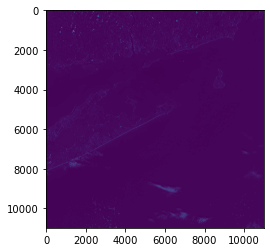

In [91]:
from matplotlib import pyplot
src = rasterio.open(selected_item.assets["B03"].href)
pyplot.imshow(src.read(1), cmap='viridis')
pyplot.show()

## Getting Assets

In [76]:
# get all keys from all items
keys = set([k for i in items for k in i.assets])
keys
#for key in keys:
 #   items.download(key=key)

{'AOT',
 'B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B09',
 'B11',
 'B12',
 'B8A',
 'SCL',
 'WVP',
 'info',
 'metadata',
 'overview',
 'thumbnail',
 'visual'}

In [105]:
for x in selected_item.assets.values():
    print(x.href)

https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/18/T/YL/2021/9/19/0/preview.jpg
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/L2A_PVI.tif
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/18/T/YL/2021/9/19/0/tileInfo.json
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/18/T/YL/2021/9/19/0/metadata.xml
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B02.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B03.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-

In [106]:
# Create empty list
download_urls = []

# for each item within our item list get the values of the assets

for x in selected_item.assets.values():
    #save url to list
    download_urls.append(x.href)
    # print the urls
    print(x.href)

https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/18/T/YL/2021/9/19/0/preview.jpg
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/L2A_PVI.tif
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/18/T/YL/2021/9/19/0/tileInfo.json
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/18/T/YL/2021/9/19/0/metadata.xml
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B02.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B03.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/T/YL/2021/9/S2A_18TYL_20210919_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-

## Downloading the list of images

Let's say that you want to download all the images you have found to your local hard drive. We can take the list from above and create a for loop to download from the list.
If we want to work locally, load these images into QGIS we can.

In [107]:
import os
import urllib

def get_filename(url):
    """
    Parses filename from given url
    """
    if url.find('/'):
        return url.rsplit('/', 1)[1]

# Filepath to save to
outdir = "/Users/laurenyee/Desktop/Projects/STAC/stac-tutorial/sentinel-data/"

# Create folder if it does no exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Download files
for url in download_urls:
    # Parse filename
    fname = get_filename(url)
    outfp = os.path.join(outdir, fname)
    # Download the file if it does not exist already
    if not os.path.exists(outfp):
        print("Downloading", fname)
        r = urllib.request.urlretrieve(url, outfp)

## Data saved locally

We demostrated that you can use rasterio directly with a url for an asset to visualize it. This is useful for quickly checking an image or creating a reproducible notebook.
However, often we work with data that is saved **locally** or data on our own computer.


`rasterio.open()` functions like the python standard library function open for opening files. The block of code within the with `...` as statement is executed once the file is opened, and the file is closed when the context manager exits. This means that we don’t have to manually close the raster file, as the context manager handles that for us.

Instead of a local file path, rasterio knows how to read URLs too, so we just passed the link to the file on AWS

`src.profile` is a collection of metadata for the file.

In [ ]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(example_url) as src:
   oviews = src.overviews(1) # list of overviews from biggest to smallest
   oview = oviews[-1] # let's look at the smallest thumbnail
   print('Decimation factor= {}'.format(oview))
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Pixels outside the imaged area are clearly set to “0”. The colormap could be improved if we change the out of bounds area to NaN. To do this we have to convert the datatype from uint16 to float32 (so be aware the array with NaNs will take 2x the storage space)

In [ ]:
with rasterio.open(example_url) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

### Calculate NDVI

NDVI is a simple indicator that can be calculated by obtaining the red and near IR bands of a satellite image. The difference in values between these two sensors can be used to evaluate healthy vegetation or 'greenness'. 

In [ ]:
# Create a function called calc_ndvi to calculate NDVI
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

Let's find the url of the red and NIR bands and assign them to a red and nir variable respectively

In [ ]:
redband = example_url
nirband = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/B08.tif'


with rasterio.open(redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

with rasterio.open(nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))



Now we can use our function and assign it to `ndvi` and plot the results

In [ ]:
ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
#plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Save Result Locally

So far we just read in the data into python from a url. If we want to save our results locally we can.

In [ ]:
localname = 'NDVI_calc.tif'
#open the NIR band and copy the meta data
with rasterio.open(nirband) as src:
    profile = src.profile.copy()
#update the existing meta data
    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

## Resources

This tutorial derived content from many different sources such as:

http://sat-utils.github.io/sat-api/#tocsbbox

https://github.com/sat-utils/sat-search/blob/master/tutorial-1.ipynb

https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/

https://developers.planet.com/planetschool/introduction-to-stac-part-1-an-overview-of-the-specification/


